In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

No bootstrapping on this either so will need to combine into one notebook

Something about the a4 datasets is making this ill coniditoned for the solver/breaking figure it out
adni data seems fine tho 

In [27]:
data = pd.read_csv("construct_ggm/pet_graphs/adni/adni_amy_tau_merged_cent_low_quartile.csv",index_col=0)
data.sample(3)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,...,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
RID,,,,,,,,,,,,,,,,,,,,,
6080,1.282,1.395,1.359,1.278,1.100,1.331,1.291,1.327,1.840,0.995,...,1.222,1.260,1.324,1.285,1.035,1.298,1.249,1.244,1.247,1.252
6328,0.982,1.146,1.031,0.869,0.906,0.987,0.882,0.942,1.356,0.635,...,0.817,0.953,1.107,0.996,0.953,1.031,0.724,1.008,1.193,0.977
6541,1.234,1.022,1.274,1.127,0.911,0.936,0.967,0.991,1.611,0.999,...,1.012,1.143,1.171,1.061,0.996,0.972,1.262,1.092,1.119,1.054


In [28]:
# #for instance figure out exactly what data I want to do this on (both these versions have hippocampus)
# data = pd.read_csv("construct_ggm/pet_graphs/a4/a4_amy_tau_merged_cent_low_quartile.csv",index_col=0)
# data.sample(3)

In [29]:
print(data["CENTILOIDS"])


RID
120     32.0
618     46.0
677     45.0
896     35.0
1280    33.0
        ... 
7050    45.0
7079    39.0
6544    32.0
6581    28.0
6586    40.0
Name: CENTILOIDS, Length: 104, dtype: float64


In [30]:
#drop centiloids
data = data.drop(columns="CENTILOIDS")

In [31]:
# data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0)
# data.sample(3)

In [32]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

In [33]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [34]:
alphas = np.linspace(0.05,1.,128)
precision_nonzero = []
covariance_nonzero = []
log_likelihoods = []

n_features = len(data_scaled.columns)
n_samples = len(data_scaled)

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-3, mode='cd', eps=1e-6, assume_centered=True)
    model.fit(data_scaled)

    log_likelihoods.append(model.score(data_scaled))
    precision_nonzero.append(np.count_nonzero(model.precision_))
    covariance_nonzero.append(np.count_nonzero(model.covariance_))

log_likelihoods = np.array(log_likelihoods)
precision_nonzero = np.array(precision_nonzero)
covariance_nonzero = np.array(covariance_nonzero)

  0%|          | 0/128 [00:00<?, ?it/s]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 8.072e-03
  warnings.warn(
  1%|          | 1/128 [00:03<06:22,  3.01s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.534e-02
  warnings.warn(
  3%|▎         | 4/128 [00:06<02:21,  1.14s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.490e-02
  warnings.warn(
  4%|▍         | 5/128 [00:08<03:22,  1.65s/it]/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphic

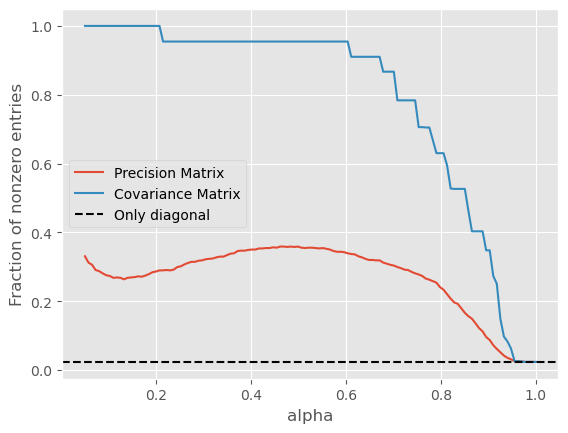

In [35]:
plt.plot(alphas,precision_nonzero/n_features**2,label="Precision Matrix")
plt.plot(alphas,covariance_nonzero/n_features**2,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend()

On the adni cent low data, seems like the precon matrix and cov matrix go to 0 nonzero entries clost to 1 

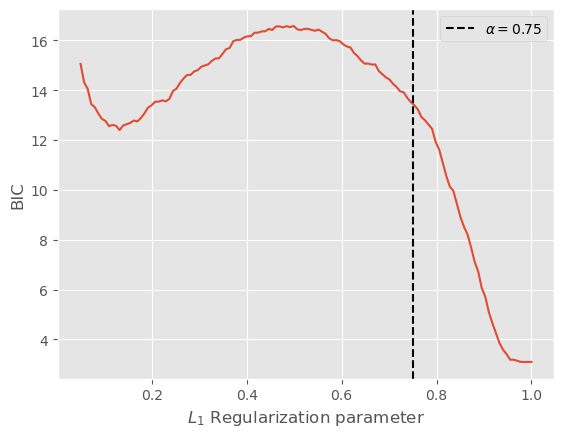

In [36]:
bics = (- 2 * log_likelihoods + ((precision_nonzero - n_features)/2 + n_features) * np.log(n_samples))/n_samples

plt.plot(alphas,bics)
plt.ylabel("BIC")
alpha = 0.75
plt.axvline(alpha,color='k',linestyle='--',label=r"$\alpha="+str(alpha)+"$")
plt.xlabel(r"$L_1$ Regularization parameter")
plt.legend();


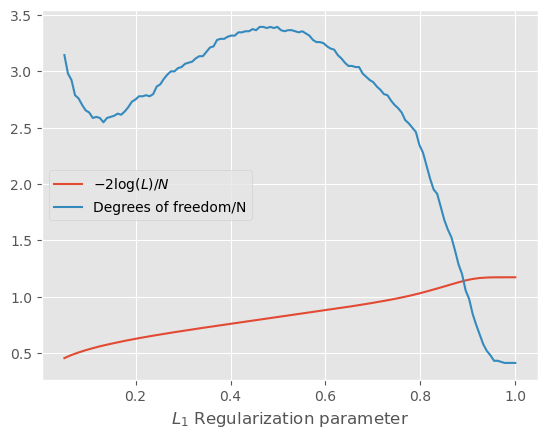

In [37]:
plt.plot(alphas,-2*log_likelihoods/n_samples,label=r'$-2 \log(L)/N$')
plt.plot(alphas,((precision_nonzero - n_features)/2 + n_features)/n_samples,label='Degrees of freedom/N')
plt.legend()
# plt.plot(alphas,bics)
plt.xlabel(r"$L_1$ Regularization parameter");

# Make graphs